# Introduction to Japanese NLP in Python

This lecture presents some basic NLP concepts such as tokenization, part-of-speech, word frequencies, tfidf score, similarity scores, and also provides guidance over a practical experience of process the Japanese wikipedia, visualize its content, calculate automatically the most relevant keywords of each article and find out a way to calculate how much related are two articles.

---
First of all, let's install some tools that we will be using and import the necessary libraries to work during this notebook:

In [8]:
# Please execute this cell to install the necessary tools
# Install mecab tool
!pip install mecab-python3
# Install word cloud
!pip install wordcloud

In [0]:
# Please execute this cell to import the necessary libraries
# Import the libraries
import MeCab
from collections import Counter
import codecs
import nltk
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from math import log
import re
import sqlite3
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [10]:
# Please execute this cell to download the necessary japanese fonts for visualization.
# Download the necessary fonts for adding japanese words in graphs:
!wget https://oscdl.ipa.go.jp/IPAexfont/IPAexfont00301.zip
!unzip IPAexfont00301.zip
# Download the necessary fonts to make the word cloud in japanese 
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!unzip NotoSansCJKjp-hinted.zip

--2019-10-22 09:37:05--  https://oscdl.ipa.go.jp/IPAexfont/IPAexfont00301.zip
Resolving oscdl.ipa.go.jp (oscdl.ipa.go.jp)... 192.218.88.241
Connecting to oscdl.ipa.go.jp (oscdl.ipa.go.jp)|192.218.88.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9429003 (9.0M) [application/zip]
Saving to: ‘IPAexfont00301.zip’

IPAexfont00301.zip  100%[===================>]   8.99M  1021KB/s    in 9.3s    

2019-10-22 09:37:15 (993 KB/s) - ‘IPAexfont00301.zip’ saved [9429003/9429003]

Archive:  IPAexfont00301.zip
   creating: IPAexfont00301/
  inflating: IPAexfont00301/ipaexg.ttf  
  inflating: IPAexfont00301/ipaexm.ttf  
  inflating: IPAexfont00301/IPA_Font_License_Agreement_v1.0.txt  
  inflating: IPAexfont00301/Readme_IPAexfont00301.txt  
--2019-10-22 09:37:18--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.210.128, 2607:f8b0:400c:c0f::80
Con

---
### NLP (Natural Language Processing)
Natural Language Processing is the area of study in computer science that focus on the computational techniques to process and produce information in natural language form. In other words, it tries to make computer programs to understand the information presented in human language form.
It is an inter-disciplinary field that ranges from very mechanical algorithms for processing strings of characters efficiently, as well as very sofisticated models that try to capture complex linguistic phenomena such as structure of a discourse, nuances in prosody or the hidden sarcasm in a product review.
In this lecture we will present the initial concepts needed to have a practical application of NLP to get some interesting results.
We will talk about how to process the text to get its basic components (words), how to observe their distribution, how to use that inforamtion to create a simplified representation of a document based on its most relevant words, and how to measure the similarity between these representations.

### Tokenization 
In NLP one of the initial tasks that we need to perform is the tokenization of the text we want to analyze.

Tokenization is the process of dividing the text into smaller parts that are called tokens. Usually this means spliting the text into word tokens.
Depending on the analysis that we want to perform or the task to be learn (use them as features in a Machine Learning model for example), we might be interested in tokenizing at sentences, at words, at morphemes (subunits of meaning) or other subunits.
This stage is also called chunking when using multiword tokens (multitoken spans).

The purpose of tokenization is to allow the computer to distinguish what are the components of a document and their relation. For example if the same words are occurring several times in the text, and use them as input for other types of analysis or tasks, like syntactic parsing (形態素解析) which aims at tagging automatically the syntactic relationship between words in that given sentence.

There is a theoretical discussion in the field of linguistics about what a word really is, but this problem is in particular important for the case of Japanese.
Is it "東京大学" a word or is it two? (東京 + 大学), or is it 食べさせられる a word? or should we split it into the components (食べ + させ + られる)?
This is a very hard problem, and again the definition will depend on the task that is aimed to be solved.

### Normalization, Stemming and Lemmatization
One of the properties of natural language and its writting systems is irregularity and the capability of being able to express the same concepts in different ways.

This ambiguity is present in multiple levels: it could be just spelling differences (abbreviations, lowercase/uppercase):
```
monday, Monday, Mon., mon.
```
Or it could include more complex variations, as it is the case with japanese numerals:
```
2,２, に, 二, 二つ, ２個、２台、２枚、...
```
This makes the dataset to become very sparse, where it is difficult to find patterns from we can automatically extract useful information.
It depends on the type of analysis we aim to perform on a given text, but in most of the cases we will likely want to count all these expressions as the same token, probably replacing them by a tag like "\<NUMBER\>".

This process of collapsing all these variations, into one cannonical form of the token or a tag, is called normalization, and it is helpful to abstract ourselves from the patterns of variations to be able to see more clearly other more general patterns across the dataset.

```
パンを六つ買いました
店を出た時にひとつ落ちました。
そのあと２個食べました。
３つ余りました。
```

```
パンを<NUMBER><VERB>
店を出た時に<NUMBER><VERB>
そのあと<NUMBER><VERB>
<NUMBER><VERB>。
```

Another thing to take into account, specially when handling morphologically rich languages (languages with inflections and attached postpositions), is that the same "word" or concept can take different forms depending on their function in the sentence.

One example in the case of Japanese language will be verbs, where if we want to get a grasp of what words are in a given text by counting their words frequencies, we probably don't want to count all these variations as different words:
 ```
 食べる, 食べられる、食べさせる、食べさせられる、食べた、食べましょう、食べている、食べていた 、など
 ```

There are several strategies for normalization: spelling canonicalization,  replacing expressions with tags, etc.
But the most common (simplest to implement) are Stemming and Lemmatization.

Stemming is the process of discarding the inflected part of the word and keep only the *stem*. In the previous example this will be:
```
食べる, 食べられる、食べさせる、食べさせられる、食べた、...  ==> 食べ
```

Lemmatization is the process of replacing the inflected words by their uninflected forms or *lemmas*. In the previous example this will be:
```
食べる, 食べられる、食べさせる、食べさせられる、食べた、... ==> 食べる
```

### Part of Speech Tagging
Once we can recognize the words or subcomponents of a sentences. It is very useful to understand what is the role of each word in that given sentence.
POS (Part of Speech) tagging, is the process of tagging each token or list of tokens with a tag that indicates the syntactical function of that word in the sentence. 

For example, in these english sentences the same word "run" have different POS tags as they are performing different functions on each sentence:
```
I [run] everyday.                ===>  verb
This is my first [run]           ===>  noun
```

POS are very useful to detect grammatical patterns, such as negations and other types of expressions when it comes to semantic parsing. They are also very reliable signals for other algorithms such as Named Entity Recognition, Sentiment Analysis, etc.



### Introducing MeCab: a Japanese syntactic analyzer (tokenizer, POS tagger, lemmatizer)

Building a proper tokenizer, Lemmatizer, Stemmer and Part of Speech Tagger is a very challengingn task and also it is still an active area of research and there are several approaches: Machine Learned models, rule base systems, dictionaries, heuristics, etc.

It is too much work and too complicated to build a solution from scratch that works to an acceptable level. It is better to avoid reinventing our tools and try to reutilize what it is available as much as possible. The widely accepted de-facto tool for Japanese is MeCab.

Mecab is a syntactic analyzer that tokenizes japanese text into tokens that are roughly equivalent to word units but with a more fine grained components, and provides POS tags as well as lemmatization of the tokens.

Let's define a function that prints the output of mecab syntactic analysis so we can re use it later in this notebook. 

In [0]:
def print_syntatic_analysis(sentence):
  tagger = MeCab.Tagger()
  text = sentence
  node = tagger.parseToNode(text) 

  while(node):
      if node.surface != "":
          print(node.surface +"\t"+ node.feature)
      node = node.next
      if node is None:
          break

In [12]:
print_syntatic_analysis('NLPはとても楽しいです。')

NLP	名詞,固有名詞,組織,*,*,*,*
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
とても	副詞,助詞類接続,*,*,*,*,とても,トテモ,トテモ
楽しい	形容詞,自立,*,*,形容詞・イ段,基本形,楽しい,タノシイ,タノシイ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
。	記号,句点,*,*,*,*,。,。,。


For the sentence "NLPはとても楽しいです。", this will be Mecab output:
```
NLP	名詞,固有名詞,組織,*,*,*,*
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
とても	副詞,助詞類接続,*,*,*,*,とても,トテモ,トテモ
楽しい	形容詞,自立,*,*,形容詞・イ段,基本形,楽しい,タノシイ,タノシイ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
。	記号,句点,*,*,*,*,。,。,。
```

This is basically showing 8 columns, with the following contents:
```
{Surface Form}, surface form: just the token as it was in the original text
{POS},
{POS1},
{POS2},
{POS3},
{Inflection Type},
{Inflecion Form},
{Lemma},
{Katakana Transliteration},
{Phonetic Reading: Katakana}
```

And each row will represent a different token: 
```
['NLP', 'は', 'とても', '楽しい', 'です', '。']
```

Let's see what happens with a highly inflected phrase like：

In [13]:
# Explain concepts: tokenization, lemma, pos, mecab features.
print_syntatic_analysis('食べさせてもらえますか?')

食べ	動詞,自立,*,*,一段,未然形,食べる,タベ,タベ
させ	動詞,接尾,*,*,一段,連用形,させる,サセ,サセ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
もらえ	動詞,非自立,*,*,一段,連用形,もらえる,モラエ,モラエ
ます	助動詞,*,*,*,特殊・マス,基本形,ます,マス,マス
か	助詞,副助詞／並立助詞／終助詞,*,*,*,*,か,カ,カ
?	名詞,サ変接続,*,*,*,*,*


The output is the following:
```
食べ	動詞,自立,*,*,一段,未然形,食べる,タベ,タベ
させ	動詞,接尾,*,*,一段,連用形,させる,サセ,サセ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
もらえ	動詞,非自立,*,*,一段,連用形,もらえる,モラエ,モラエ
ます	助動詞,*,*,*,特殊・マス,基本形,ます,マス,マス
か	助詞,副助詞／並立助詞／終助詞,*,*,*,*,か,カ,カ
```

You can see how the word is splitted into their minimal meaningful components and we can see in the 7th column the lemmatization of each of the components:
食べる +させる、+て, +もらえる, +ます

Let's see one more example with a more complicated structure:

In [0]:
# Explain concepts: tokenization, lemma, pos, mecab features.
print_syntatic_analysis('食べさせられたくなかったら、手を上げてください。')

食べ	動詞,自立,*,*,一段,未然形,食べる,タベ,タベ
させ	動詞,接尾,*,*,一段,未然形,させる,サセ,サセ
られ	動詞,接尾,*,*,一段,連用形,られる,ラレ,ラレ
たく	助動詞,*,*,*,特殊・タイ,連用テ接続,たい,タク,タク
なかっ	助動詞,*,*,*,特殊・ナイ,連用タ接続,ない,ナカッ,ナカッ
たら	助動詞,*,*,*,特殊・タ,仮定形,た,タラ,タラ
、	記号,読点,*,*,*,*,、,、,、
手	名詞,一般,*,*,*,*,手,テ,テ
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
上げ	動詞,自立,*,*,一段,連用形,上げる,アゲ,アゲ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
ください	動詞,非自立,*,*,五段・ラ行特殊,命令ｉ,くださる,クダサイ,クダサイ
。	記号,句点,*,*,*,*,。,。,。


Now that we understand these basic concepts and we can use Mecab tool, let's see what we can do with it in a real natural language dataset to do some real NLP!

# Hands on: Japanese Wikipedia

We will work with a dump of the Japanese Wikipedia, but due to time and memory constraints we will use only a slice (the first 106k articles) as given in the official wikipedia dumps website.

Only using this slice of the full wikipedia it still takes around 40 mins ~  1 hour to download the dump file and extract the articles text into a the text file, we are seting up the text file in a download link so we can directly work on the preprocessing of the text file with the already extracted artilces text.

In [0]:
# Download the text file with the extracted articles.
!wget -O japanese_wikipedia_extracted_articles.txt https://filebin.net/c9y2rs2g166nwy95/japanese_wikipedia_extracted_articles__1_?t=c7w6bpfj
# TODO!: the link above should be replaced by <path-for-downloading-japanese_extracted_articles>

--2019-10-21 01:36:47--  https://filebin.net/c9y2rs2g166nwy95/japanese_wikipedia_extracted_articles__1_?t=c7w6bpfj
Resolving filebin.net (filebin.net)... 185.47.40.36, 2a02:c0:2f0:700:f816:3eff:fe73:c194
Connecting to filebin.net (filebin.net)|185.47.40.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 357505028 (341M) [text/plain]
Saving to: ‘japanese_extracted_articles’

japanese_extracted_ 100%[===================>] 340.94M  12.2MB/s    in 31s     

2019-10-21 01:37:20 (10.9 MB/s) - ‘japanese_extracted_articles’ saved [357505028/357505028]



Let's explore the contents of the processed text file to see what we have:

In [17]:
# Show the first 30 lines of the text file content
!head -n 30 japanese_wikipedia_extracted_articles.txt

<doc id="5" url="https://ja.wikipedia.org/wiki?curid=5" title="アンパサンド">
アンパサンド

アンパサンド (, &) とは「…と…」を意味する記号である。ラテン語の の合字で、Trebuchet MSフォントでは、と表示され "et" の合字であることが容易にわかる。ampersa、すなわち "and per se and"、その意味は"and [the symbol which] by itself [is] and"である。

その使用は1世紀に遡ることができ (1)、5世紀中葉 (2,3) から現代 (4-6) に至るまでの変遷がわかる。
Z に続くラテン文字アルファベットの27字目とされた時期もある。

アンパサンドと同じ役割を果たす文字に「のet」と呼ばれる、数字の「7」に似た記号があった(, U+204A)。この記号は現在もゲール文字で使われている。

記号名の「アンパサンド」は、ラテン語まじりの英語「& はそれ自身 "and" を表す」(& per se and) のくずれた形である。英語以外の言語での名称は多様である。

日常的な手書きの場合、欧米でアンパサンドは「ε」に縦線を引く単純化されたものが使われることがある。

また同様に、「t」または「+（プラス）」に輪を重ねたような、無声歯茎側面摩擦音を示す発音記号「」のようなものが使われることもある。

プログラミング言語では、C など多数の言語で AND 演算子として用いられる。以下は C の例。
PHPでは、変数宣言記号（$）の直前に記述することで、参照渡しを行うことができる。

BASIC 系列の言語では文字列の連結演算子として使用される。codice_4 は codice_5 を返す。また、主にマイクロソフト系では整数の十六進表記に codice_6 を用い、codice_7 （十進で15）のように表現する。

SGML、XML、HTMLでは、アンパサンドを使ってSGML実体を参照する。



</doc>
<doc id="10" url="https://ja.wikipedia.org/wiki?curid=10" title="言語">
言語

この記事では言語（げんご）、特に自然言語について述べる。


You will see that this file is structured in the following way:
```
<doc id="{article-id}" url="{article-url}" title="{article-title}">
{article-text}
</doc>
<doc id="{article-id}" url="{article-url}" title="{article-title}">
{article-text}
</doc>
...
```

So even if this is a text dump, we still have html tags to separate where an article starts and ends as well as providing some metadata like the url, the title, and its id.

### Calculating Word Frequencies

One of the simplests analysis we can perform of a given natural language dataset is to calcluate its statistics.

Word frequencies are very meaningful and could reveal a lot of information about a given document.

Most of the popular techniques in NLP are based in some form of word frequency calculation or in a calculation derived from word frequencies.
For that reason, it is very important to properly pre-process the documents we are going to work with.

In other words, we need to be sure that we tokenize and normalize our documents correctly so we can be sure that the word frequencies will represent faithfully the context of the document.
Usually this is a very iterative process where we need to apply some normalization strategy, take a look at the results, analyze their distribution, evaluate how relevant is to the task we want to perform and how much noise we are still getting in our data.

Due to time constraints we can't have explore in details during this activity, we we will see what happens when we analyze and visualize the Wikipedia text dump as it is, and what we can get after applying some normalization and preprocessing of the data.


In [0]:
def count_all_word_frequencies():
  all_words = []
  tagger = MeCab.Tagger()
  with codecs.open("japanese_wikipedia_extracted_articles.txt", "r",'utf-8') as file:
    for line in file:
        node = tagger.parseToNode(line)
        while(node):
          if node.surface != "":
            all_words.append(node.surface.lower())
          node = node.next
          if node is None:
              break
  return Counter(all_words)

In [19]:
all_words = count_all_word_frequencies()
# get the top 25 most common words and print them
for word in all_words.most_common(25):
  print("Word: {}, frequency: {}".format(word[0], word[1]))
# Exercise here will be to get the list of frequencies for bigrams. Explain examples where using bigrams is useful.

Word: の, frequency: 3512545
Word: 、, frequency: 3245139
Word: に, frequency: 2141039
Word: は, frequency: 2094666
Word: 。, frequency: 2071763
Word: を, frequency: 1805639
Word: が, frequency: 1686345
Word: た, frequency: 1672139
Word: で, frequency: 1475972
Word: て, frequency: 1163438
Word: と, frequency: 1160679
Word: し, frequency: 993385
Word: ）, frequency: 633112
Word: （, frequency: 631910
Word: れ, frequency: 629469
Word: 年, frequency: 622716
Word: さ, frequency: 613974
Word: ある, frequency: 506361
Word: も, frequency: 490642
Word: する, frequency: 472102
Word: いる, frequency: 464001
Word: 「, frequency: 439905
Word: 」, frequency: 433886
Word: ・, frequency: 385914
Word: から, frequency: 350204


### Visualizing the contents of a document: Words Frequency Distribution

In [0]:
def plot_word_frequency_distribution(word_freq_dict):
  # set the japanese fonts for displaying the words in the vocabulary
  font_properties = font_manager.FontProperties(fname='IPAexfont00301/ipaexg.ttf')
  # setup the plot size and the legend over the axis
  plt.figure(figsize=(12,5))
  plt.xticks(fontsize=13, rotation=90,fontproperties=font_properties)
  # get the frequency distribution and plot it over the top 25 words
  frequency_distribution = nltk.FreqDist(word_freq_dict)
  frequency_distribution.plot(25,cumulative=False)
  # Now plot the log-log distribution of all words frequencies
  word_counts = sorted(word_freq_dict.values(), reverse=True)
  plt.figure(figsize=(12,5))
  plt.loglog(word_counts, linestyle='-', linewidth=1.5)
  plt.ylabel("Freq")
  plt.xlabel("Word Rank")

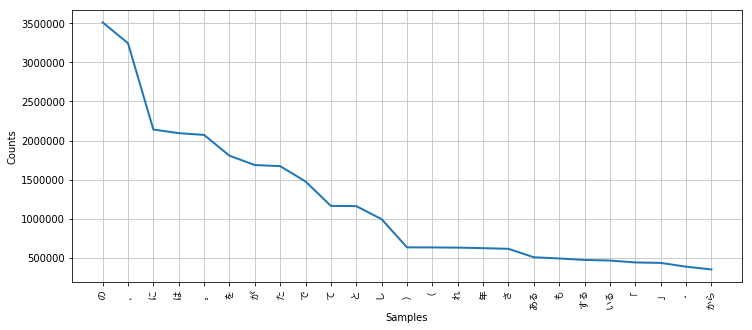

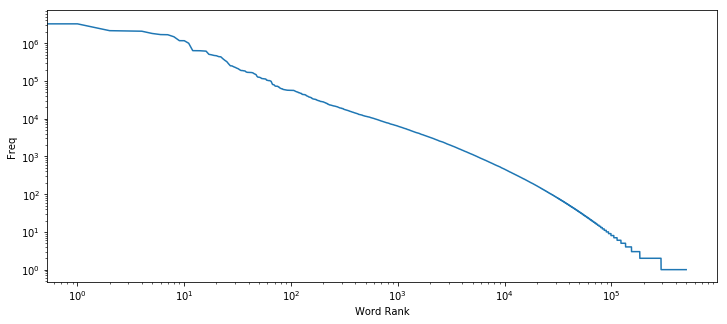

In [21]:
plot_word_frequency_distribution(all_words)

In [0]:
def make_word_cloud(words_freq_dict):
  # setup Japanese font for creating the word cloud
  font_path = 'NotoSansCJKjp-Light.otf'
  # create an image with a Word Cloud with the given word frequencies
  wordcloud = WordCloud(width=1500,
                        height=1000,
                        max_words=900,
                        colormap='Blues',
                        font_path=font_path,
                        normalize_plurals=True).generate_from_frequencies(words_freq_dict)
  # setup a plot frame without any axis and print the image generated above  
  plt.figure(figsize=(17,14))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

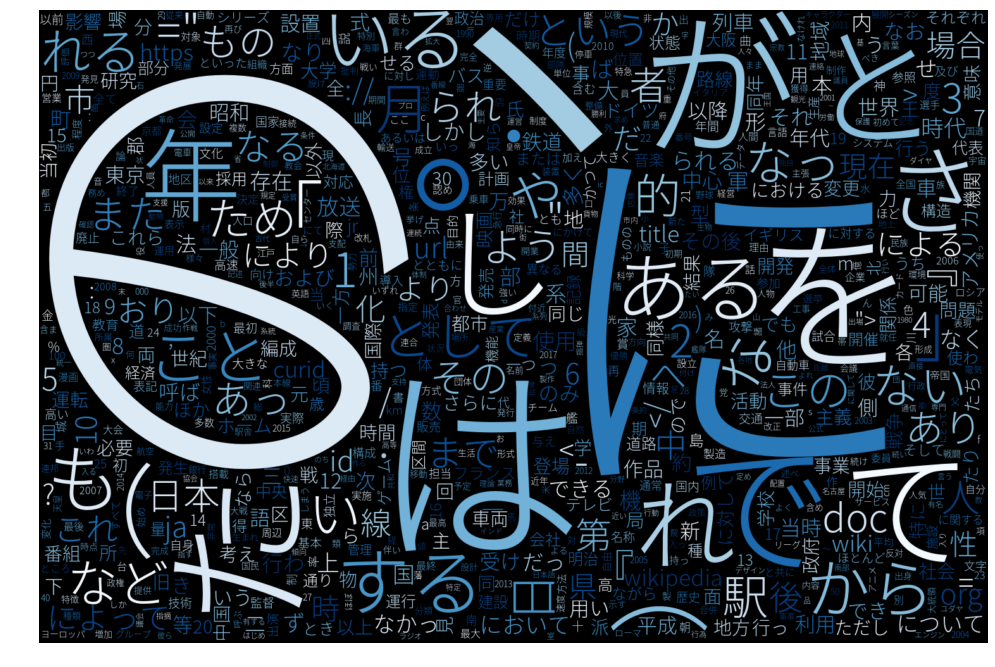

In [23]:
make_word_cloud(all_words)

As you can see this is not very insighful about the content of the document we are processing, but it gives us some hints of what it may be happening.

We can see that punctuations symbols ("・", "」", "「", etc) and particles (の、に、は、を、が) are getting the higher frequency values.

As we are not going to perform any grammatical analysis on phrase structures, we could easily discard these words, as well as numbers, auxiliary verbs, etc and only leave nouns, adjectives and verbs to represent our documents.

Now let's run this again but this time:
* we will use only the words lemmas for the words we are going to count.
* we will accept only specific types of words (nouns, verbs and adjectives).
* we will filter words using a blacklist to discard common/frequent words that are not interesting for our purpose.

In [0]:
# Break it into incremental improvements.
def count_word_frequencies(text, stopwords, word_categories, word_categories_to_avoid):
  all_nouns_verbs_adjs = []
  tagger = MeCab.Tagger()
  for line in text:
      node = tagger.parseToNode(line)
      while(node):
        lemma = node.feature.split(',')[6].lower() # keep dictionary form
        pos = node.feature.split(',')[0].lower()
        pos2 = node.feature.split(',')[1].lower()
        if lemma != '':
          if lemma == '*' and node.surface != "":
            lemma = node.surface
          if (pos in word_categories and
              pos2 not in word_categories_to_avoid and
              lemma not in stopwords):
            all_nouns_verbs_adjs.append(lemma)
        node = node.next
        if node is None:
            break
  return Counter(all_nouns_verbs_adjs)

In [25]:
stopwords = ['する', 'なる', 'ない', 'これ', 'それ', 'id', 'ja', 'wiki',
             'wikipedia', 'id', 'doc', 'https', 'org', 'url', 'いう', 'ある',
             'curid', 'あれ', 'それら', 'これら', 'それそれ', 'それぞれ',
             'title', 'その後', '一部', '前', 'よる', '一つ', 'ひとつ', '他',
             'その他', 'ほか', 'そのほか', 'いる']
word_categories = ['名詞', '動詞', '形容詞']
word_categories_to_avoid = ['非自立', '接尾', 'サ変接続', '数']
with codecs.open("japanese_wikipedia_extracted_articles.txt", "r",'utf-8') as text:
  all_nouns_verbs_adjs = count_word_frequencies(text, stopwords, word_categories, word_categories_to_avoid)
for word in all_nouns_verbs_adjs.most_common(25):
  print("Word: {}, frequency: {}".format(word[0], word[1]))

Word: 月, frequency: 225569
Word: 日本, frequency: 101733
Word: 行う, frequency: 95975
Word: できる, frequency: 75939
Word: 場合, frequency: 64787
Word: 多い, frequency: 58207
Word: 現在, frequency: 56723
Word: 呼ぶ, frequency: 56646
Word: 時代, frequency: 50671
Word: 駅, frequency: 43913
Word: 持つ, frequency: 43100
Word: 列車, frequency: 39593
Word: 受ける, frequency: 38427
Word: 世界, frequency: 37584
Word: 当時, frequency: 37364
Word: 用いる, frequency: 35237
Word: 作品, frequency: 33411
Word: 昭和, frequency: 32837
Word: 東京, frequency: 32593
Word: 可能, frequency: 32419
Word: 使う, frequency: 32191
Word: 以降, frequency: 31423
Word: 鉄道, frequency: 31139
Word: 一般, frequency: 30777
Word: 多く, frequency: 30023


In [27]:
# See what is the content of all_nouns_verbs_adjs
print([p for p in all_nouns_verbs_adjs.items()][:10])

[('アンパサンド', 12), ('記号', 3790), ('ラテン語', 2121), ('合', 888), ('字', 5778), ('Trebuchet', 1), ('MS', 2502), ('フォント', 812), ('et', 379), ('容易', 3320)]


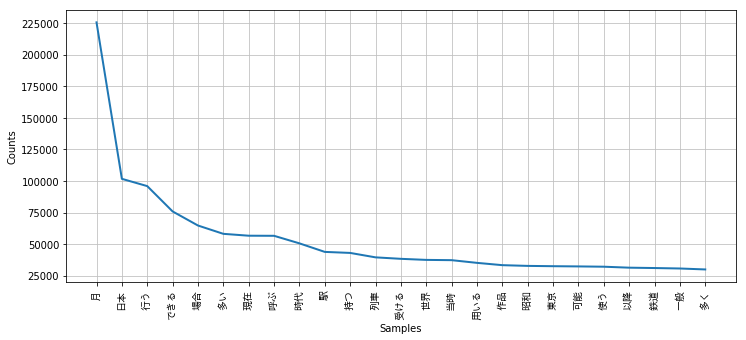

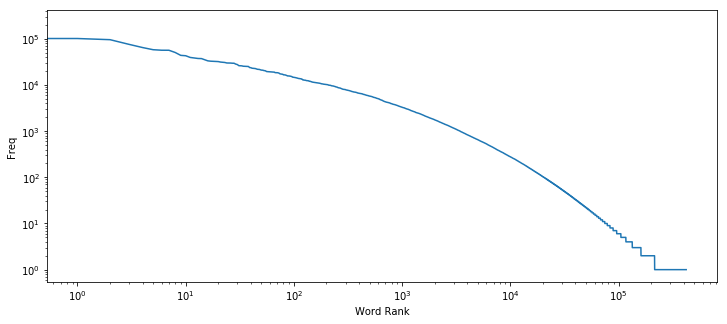

In [28]:
plot_word_frequency_distribution(all_nouns_verbs_adjs)

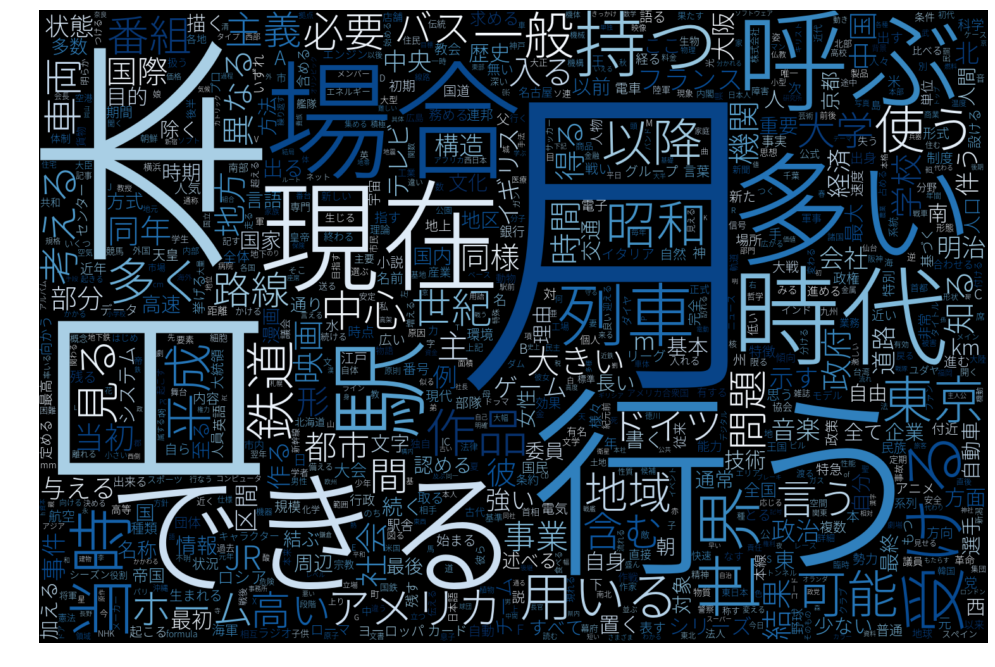

In [29]:
make_word_cloud(all_nouns_verbs_adjs)

This is much more representative of the contents of Wikipedia!


### Playing with Wikipedia Articles

Due to time restrictions it will take too much time to do all the wikipedia preprocessing during the lecture. So we have prepared a database file with all the already preprocessed word frequencies over the Japanese wikipedia articles so we can query it to explore on an article level how the document is visualized and represented. 

[Reference Notebook describing the process for preprocessing and saving it into a local databse](https://colab.sandbox.google.com/drive/1C8QZlXQlAZKsRdfM950Zbp0s5eMR5ziG#scrollTo=m-Mtjjrx1Bwv)

Download the database file:

In [0]:
# Download the databse file with the preprocessed word frequencies.
#!wget -O japanese_wikipedia_analysis.db https://filebin.net/c9y2rs2g166nwy95/japanese_wikipedia_extracted_articles__1_?t=c7w6bpfj
DB_PATH = "japanese_wikipedia_analysis.db"

Here we provide with some helper functions that can retrieve articles from the database by title as well as retrieve an arbitrary amount of random articles:

In [0]:
def retrieve_random_articles(db_path, amount_articles):
  db_connection = sqlite3.connect(db_path)
  retrieve_statement = u"""
  SELECT title
  FROM article_text
  ORDER BY RANDOM() LIMIT """ + str(amount_articles)
  result = []
  cursor = db_connection.execute(retrieve_statement)
  for row in cursor:
      result.append(row[0])
  return result

def retrieve_articles_wordfreqs_by_title(db_path, article_title):
  db_connection = sqlite3.connect(db_path)
  retrieve_statement = u"""
  SELECT
    word,
    frequency
  FROM article_word_frequencies
  INNER JOIN article_text
   ON article_text.article_id = article_word_frequencies.article_id
  WHERE title = \"{seq}\"
  """.format(seq=article_title)
  result = []
  cursor = db_connection.execute(retrieve_statement)
  for row in cursor:
      result.append(row)
  return sorted(result, key=lambda x: x[1])

In [130]:
# retrieve 10 random articles:
print(retrieve_random_articles(DB_PATH, 10))

['松浦玲', '今仁哲夫', '石川五右衛門', '国際連合安全保障理事会決議1441', 'サンダーマスク', '黄金律', '東粉浜停留場', '高島町駅', '88年', '渡辺正行']


So, let's retrieve the word frequencies for a single wikipedia article and create a word cloud to visualize its content:

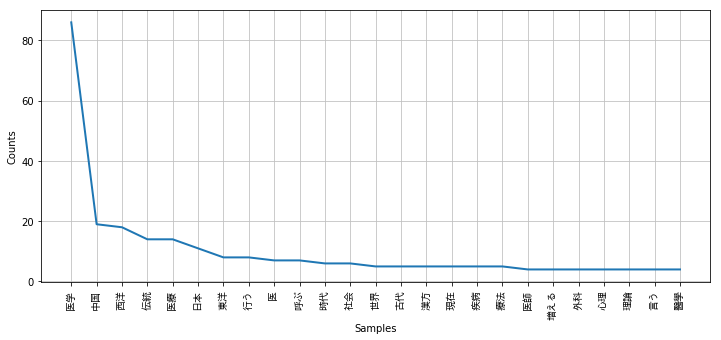

医学


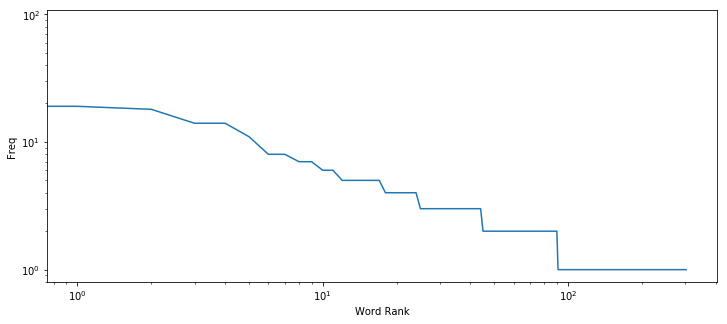

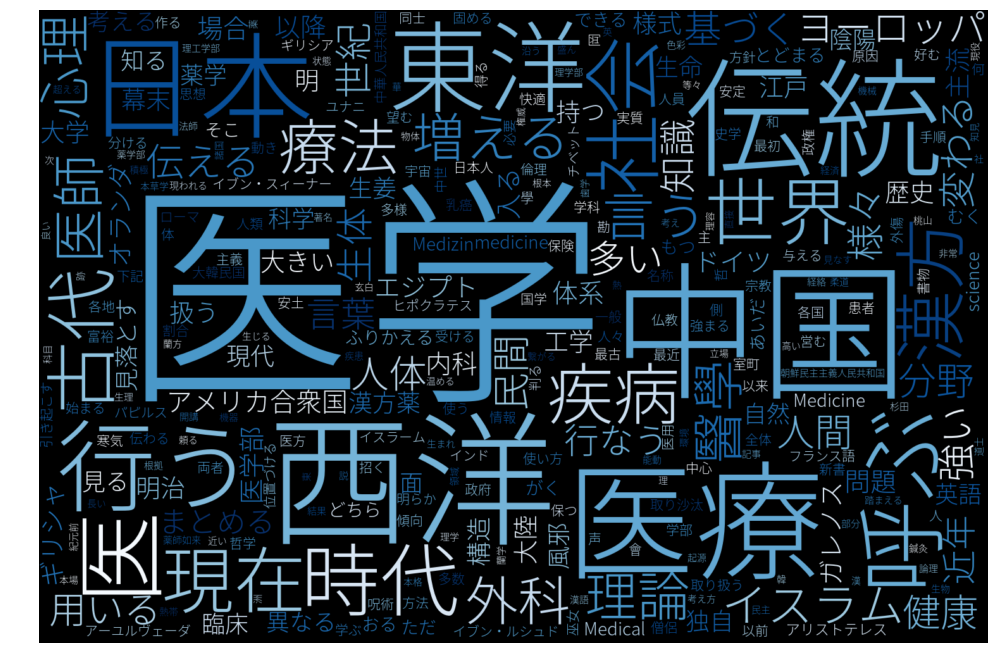

In [119]:
title = '医学'
# See distribution over words in an article
article_word_freqs = dict(retrieve_articles_wordfreqs_by_title(DB_PATH, title))
plot_word_frequency_distribution(article_word_freqs)
# Make a word cloud with the word frequencies for an article
print(title)
make_word_cloud(article_word_freqs)
# play with other articles

### What is TF-IDF? (https://en.wikipedia.org/wiki/Tf–idf)
Term frequency-inverse document frequency (TF-IDF) is a metric used to determines for a given word and a set of documents, how relevant is that word for a document in the set of documents.
It is basically a multiplication between two other metrics:
* the word frequency (how many times a word appears in a document)
* the inverse document frequency of that word across all the documents in the set.

TF-IDF was designed for information retrieval applications like document search. It refers to the increasing proportion of the number of times a word appears in a document, but it also considers the number of documents that contain that word. 
For this reason, very common words that can be observed in every document, like prepositions, and pronouns rank low even though they may appear many times in the document, because that means they don’t mean much to that document in particular.

However, if a word like "NLP" appears many times in a document, but it doesn't appear many times in most of the others documents, it probably means that it’s very relevant for this particular document.

TF-IDF has many uses, most importantly in automated text analysis, and is very useful for scoring words in machine learning algorithms for Natural Language Processing (NLP).

###How is TF-IDF calculated?
TF-IDF for a word in a document is calculated by multiplying two different metrics:

* The term frequency of a word in a document: 
There are several ways of calculating this frequency, we can just count the occurrences of the word in a document. There are also ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document, usually calculating the logarithm of the frequency with an offset of 1 is enough to take into account the lenght of the document.

* The inverse document frequency of the word across a the set of all the other documents:
Basically, this tries to capture how common or rare that word is in the entire dataset. The smaller it is its value, the more common a word is. This can be calculated by dividing the total number of documents, by the number of documents that contain that word, and calculating the logarithm.
Therefore, if the word is very frequent and common in many documents, this number will get closer to 0. Otherwise, it will approach to 1.

TF-IDF score of a word in a document is the product of multiplying these two metrics above. The bigger the value, the more relevant is that word to that document in particular.

In a more formal definition:

```
    tf_idf(t, d, D) = tf(t, d) * idf(t, D)
```
Where:
```
    tf(t, d) = log(1 + freq(t, d))
```
and
```
    idf(t, D) = log(N / count(d in D: t in d))
```
where N is the vocabulary size agregated across all d in D


### Applications of TF-IDF
Determining how relevant a word is to a document, or TD-IDF, is useful in many ways, for example:

* Information retrieval
TF-IDF was invented to deliver the most relevant results for what you are searching for in the context of document search. This metric allows you to sort every document in the dataset in order of relevance, like a search engine.

* Keyword Extraction
Another application is to use TF-IDF for extracting relevant keywords from a given text. Just by getting the top tfidf scoring words will get you the most relevant keywords.

Let's write a function that calculates it for us:

In [0]:
from math import log
def tf_idf(word, doc_word_frequencies, corpus_word_frequencies, vocabulary_size):
  return tf(word, doc_word_frequencies) * idf(word, corpus_word_frequencies, vocabulary_size)

def tf(word, doc_word_frequencies):
  return log(1 + doc_word_frequencies[word])

def idf(word, corpus_word_frequencies, vocabulary_size):
  # to avoid dividing by 0
  if word not in corpus_word_frequencies or corpus_word_frequencies[word] == 0:
    return 1
  return  log(vocabulary_size / corpus_word_frequencies[word])

Once we have a function that can calculate the tf_idf score of a word for a given document among a set of documents, we can use this to calculate the tfidf scores of every word in a wikipedia article:

In [0]:
wikipedia_frequencies = all_nouns_verbs_adjs
wikipedia_vocabulary_size = len(all_nouns_verbs_adjs)

def calculate_articles_tfidfs(db_path, title):
  article_word_frequencies = dict(retrieve_articles_wordfreqs_by_title(db_path, title))
  return dict([(word, tf_idf(word, article_word_frequencies, wikipedia_frequencies, wikipedia_vocabulary_size)) for word in article_word_frequencies.keys()])

Now let's see what we get if we visualize this as we did above for the same article:

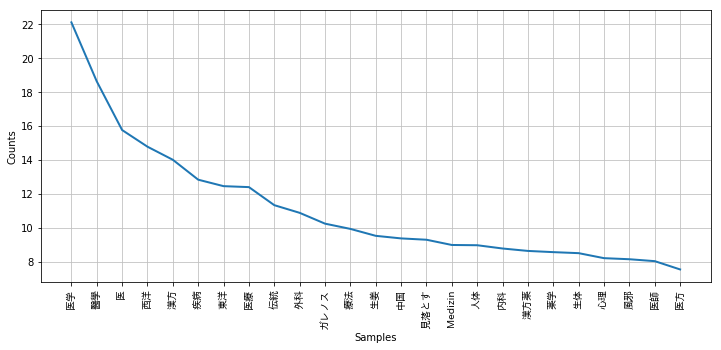

医学


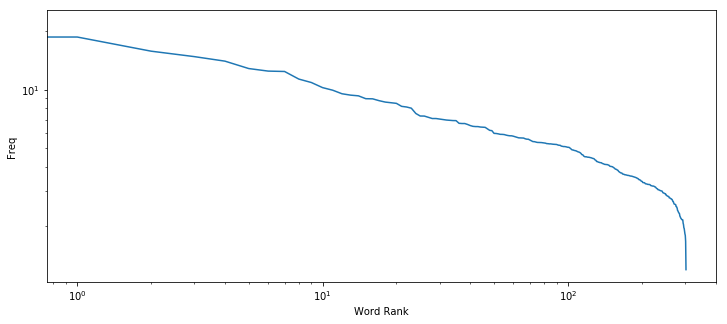

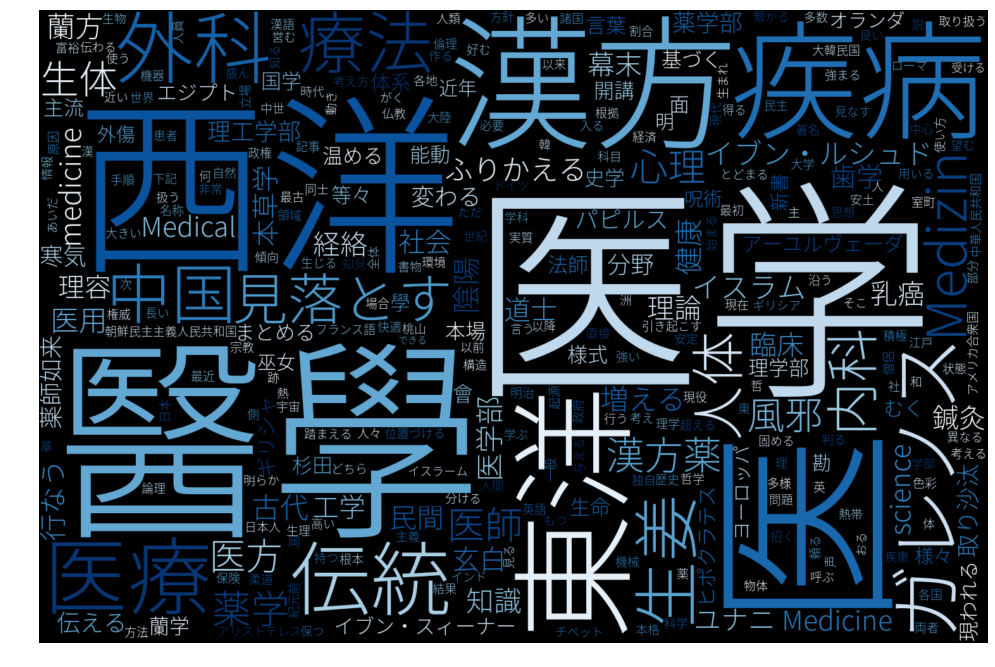

In [132]:
# Make a word cloud with the tfidf scores for the same article
title = '医学'
# See distribution over words in an article
article_words_tfidfs = calculate_articles_tfidfs(DB_PATH, title)
plot_word_frequency_distribution(article_words_tfidfs)
# Make a word cloud with the word frequencies for an article
print(title)
make_word_cloud(article_words_tfidfs)
# play with other articles

In [112]:
# Compare tfidf scores between two similar articles
tfidf1 = sorted(dict(calculate_articles_tfidfs(DB_PATH, "薬学")).items(), key=lambda x: x[1], reverse=True)
tfidf2 = sorted(dict(calculate_articles_tfidfs(DB_PATH, "医学")).items(), key=lambda x: x[1], reverse=True)
# Let's compare their top tfidf scoring words
print("These are the top scoring tfidf words for both articles:")
print("   タイトル：薬学\t|\tタイトル：医学")
for index in range(25):
  print("{}: {}\t|\t{}".format(index, tfidf1[index], tfidf2[index]))

These are the top scoring tfidf words for both articles:
   タイトル：薬学	|	タイトル：医学
0: ('薬学', 22.512175393731983)	|	('医学', 22.091790344580804)
1: ('薬剤', 13.09384590858526)	|	('醫學', 18.616641576770387)
2: ('化学', 12.175884580659265)	|	('医', 15.74878938809225)
3: ('薬理', 11.466502171826136)	|	('西洋', 14.767466852490294)
4: ('薬物', 10.879658161717835)	|	('漢方', 13.996867661723883)
5: ('衛生', 10.583595040276716)	|	('疾病', 12.824350667545804)
6: ('薬', 9.845261419271292)	|	('東洋', 12.443259066041877)
7: ('医薬品', 9.829777664130756)	|	('医療', 12.387040427629794)
8: ('医学', 9.625956893907814)	|	('伝統', 11.323220940171247)
9: ('博士', 9.543436923731443)	|	('外科', 10.871729633611764)
10: ('薬局方', 9.517283415588693)	|	('ガレノス', 10.234538025501982)
11: ('有機', 9.187512681306632)	|	('療法', 9.925440554648123)
12: ('ファーマシューティカルコミュニケーション', 8.978657145005897)	|	('生姜', 9.517283415588693)
13: ('レギュラトリーサイエンス', 8.978657145005897)	|	('中国', 9.365611183759516)
14: ('病態', 8.770936918366024)	|	('見落とす', 9.287288681174001)
15: ('生薬', 8.65

In [113]:
# Compare tfidf scores between two distant articles
tfidf1 = sorted(dict(calculate_articles_tfidfs(DB_PATH, "薬学")).items(), key=lambda x: x[1], reverse=True)
tfidf2 = sorted(dict(calculate_articles_tfidfs(DB_PATH, "ピアノ")).items(), key=lambda x: x[1], reverse=True)
# Let's compare their top tfidf scoring words
print("These are the top scoring tfidf words for both articles:")
print("   タイトル：薬学\t|\tタイトル：ピアノ")
for index in range(25):
  print("{}: {}\t|\t{}".format(index, tfidf1[index], tfidf2[index]))

These are the top scoring tfidf words for both articles:
   タイトル：薬学	|	タイトル：ピアノ
0: ('薬学', 22.512175393731983)	|	('ハンマー', 27.81915509943446)
1: ('薬剤', 13.09384590858526)	|	('ピアノ', 27.490726781131055)
2: ('化学', 12.175884580659265)	|	('弦', 26.49642539265954)
3: ('薬理', 11.466502171826136)	|	('ペダル', 25.84969088684545)
4: ('薬物', 10.879658161717835)	|	('響', 23.201530191000614)
5: ('衛生', 10.583595040276716)	|	('グランド', 23.011527914019965)
6: ('薬', 9.845261419271292)	|	('鍵盤', 22.91843640854901)
7: ('医薬品', 9.829777664130756)	|	('クリストフォリ', 22.88956503469567)
8: ('医学', 9.625956893907814)	|	('鍵', 22.520745538866915)
9: ('博士', 9.543436923731443)	|	('ダンパー', 21.828521741343224)
10: ('薬局方', 9.517283415588693)	|	('ジルバーマン', 21.41971102130351)
11: ('有機', 9.187512681306632)	|	('アコースティック', 21.317933048538947)
12: ('ファーマシューティカルコミュニケーション', 8.978657145005897)	|	('アップライトピアノ', 20.813182704797626)
13: ('レギュラトリーサイエンス', 8.978657145005897)	|	('ダブル・エスケープメント・アクション', 20.325766406933887)
14: ('病態', 8.770936918366024)	|	('

### Why is TF-IDF relevant in Machine Learning?
Machine learning algorithms are design to deal with numbers by optimizing functions but natural language data is text which does not fit on the type of data points used in a machine learning algorithm. A way to transform text into a numerical representation is by creating numerical vectors that represent our text documents. Different vectorization algorithms  (tfidf bag of words, words embeddings, etc) will have a significative impact in the overall performance.

Once we get the documents represented as numerical vectors by using each vocabulary word as a dimension of the vector, the TF-IDF score for each word  can be used as the value in that dimension creating a coordinate in a multidmensional vector space that can be used by Machine Learning algorithms.

For example, if we have the following vocabulary across all the documents in our dataset:
```
vocab = {tree, dog, day, cat, climb, one, sunny, the, walk, quickly}
```
and the following representation with its tf-idf scores for document_1:
```
document_1 = {tree: 0.65, cat: 0.81, climb: 0.9, quickly: 0.34, the: 0.02}
```
This can be represented as:
```
document_1_vector = [0.65, 0, 0, 0.81, 0.9, 0, 0, 0.02, 0, 0.34]
```
Note that this is just taking the vocabulary in the same order it was above, and replacing each word with its tf-idf score for that document, and 0 if the word was not found in the document.

Creating a vector representation like this, allows us to calculate distances between vectors in that vector space, which we can consider a type of "closeness" or "similarity" between the representation of each of these documents.

## Similarity Calculation:
As mentioned in the section above, if we can obtain numerical vectors that represents two given documents, then we can calculate the distance between the point represented by these vectors in the vector space.

Cosine similarity calculates similarity by measuring the cosine of angle between two vectors in a given space.

 This is calculated for two vectors A and B as:
![Cosine Similarity](https://miro.medium.com/max/852/1*hub04IikybZIBkSEcEOtGA.png)

In order to calculate cosine similarity, we need to convert documents into vectors.

One way to do that is to use bag of words with either TF (term frequency) or TF-IDF (term frequency- inverse document frequency). 
Cosine similarity is defined in a way that it is irrelevant if we use TF or TF-IDF, we just need to define the vectors.

In other words, we think of our vocabulary (all the words found in our documents) as the axis of a multidimensional space, where a given document will have its coordinates given by the TF-IDF score on each of the words that appeared in that document.

TF is good for text similarity in general, but TF-IDF is good for search query relevance.

Following the formula above, we can define a function that calculates the similarity between two articles in the following way:

In [0]:
from math import sqrt

# article1 and article2 are dicts of the form {word: tfidf_score}
def similarity(article1, article2):
  numerator_sum = 0
  # calculate the sum only for the words in common
  for word1 in article1:
    for word2 in article2:
      if word1 == word2:
        numerator_sum += article1[word1]*article2[word2]
  # calculate each of the square sums for all the words in each vector
  article1_squared_sum = 0
  for word in article1:
    article1_squared_sum += article1[word]**2
  article2_squared_sum = 0
  for word in article2:
    article2_squared_sum += article2[word]**2
  return numerator_sum / (sqrt(article1_squared_sum)*sqrt(article2_squared_sum))

Now let's see an example with a set of documents where two of them are similar, but not the other ones:

In [0]:
# calculate the similarity between 5 documents
def print_similarity_scores(target_article, articles_list):
  article1 = dict(calculate_articles_tfidfs(DB_PATH, target_article))
  for article_title in articles_list:
    article2 = dict(calculate_articles_tfidfs(DB_PATH, article_title))
    print("Similarity score between {} and {} is {}".format(target_article, article_title, similarity(article1, article2)))

In [121]:
print_similarity_scores("薬学", ["ピアノ", "医学", "哲学", "物理学"])

Similarity score between 薬学 and ピアノ is 0.020447803763247938
Similarity score between 薬学 and 医学 is 0.1988667850039464
Similarity score between 薬学 and 哲学 is 0.07177733511652583
Similarity score between 薬学 and 物理学 is 0.09976070811067084


In [122]:
print_similarity_scores("アルゼンチン", ["チリ", "言語", "IBM", "亜鉛"])

Similarity score between アルゼンチン and チリ is 0.33700167745062665
Similarity score between アルゼンチン and 言語 is 0.1449340984193506
Similarity score between アルゼンチン and IBM is 0.0728631860183949
Similarity score between アルゼンチン and 亜鉛 is 0.06689884075850104


As you can already tell, this can be used to find the most similar article from the whole wikipedia to a given article, or even further, the most relevant article to a given search query.


Congratulations!

Now you know:
* the basic concepts of text processing in NLP
* how to load huge datasets such as Wikipedia and process it to extract the most relevant words in a document
* how to plot the word frequency distribution for a given document
* how to create a very fancy word cloud with the most relevant words in a text
* how to write scripts that can calculate the similarity between two documents based on their tfidfs scores

This is the basics of information retrieval and how a search engine works! (in a very simplified way...) :) 